In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
df = pd.read_csv("medical_insurance.csv")
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
None


In [4]:
print(df.describe())

               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.000000    30.447500     1.000000   9333.014350
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010


In [5]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


<Figure size 1200x600 with 0 Axes>

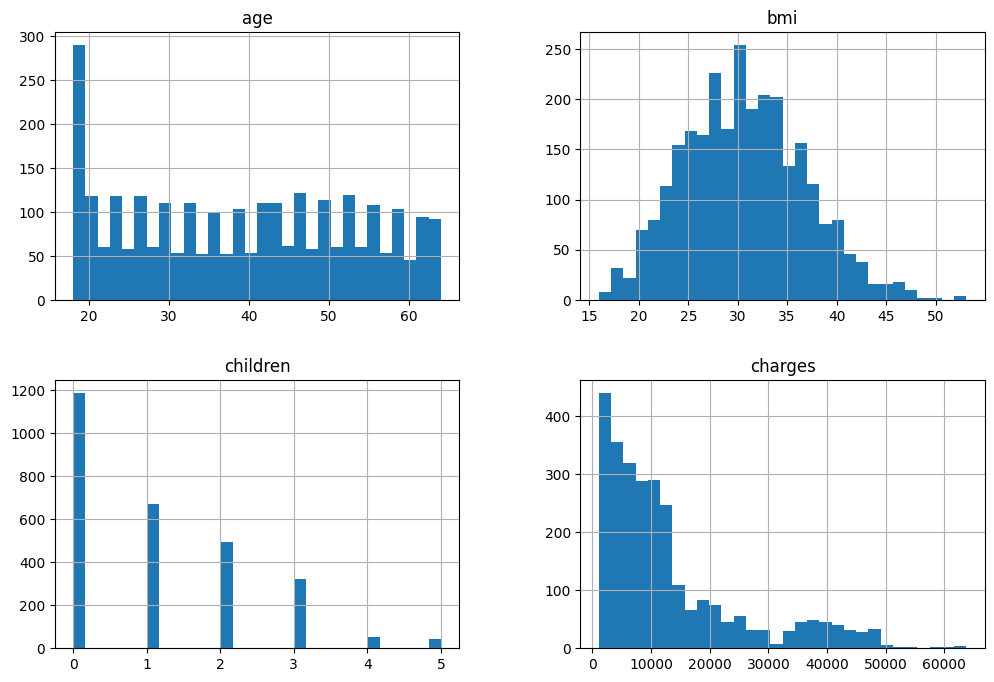

In [6]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 6))
df[numerical_cols].hist(bins=30, figsize=(12, 8))
plt.show()

In [7]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_imputer = SimpleImputer(strategy="median")
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])


In [8]:
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
encoded_cats.columns = encoder.get_feature_names_out(categorical_cols)
df = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, encoded_cats], axis=1)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0.0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18.0,33.770,1.0,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28.0,33.000,3.0,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33.0,22.705,0.0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32.0,28.880,0.0,3866.85520,1.0,0.0,1.0,0.0,0.0


In [9]:
df.fillna(df.median(), inplace=True)
print(df.isnull().sum())

age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


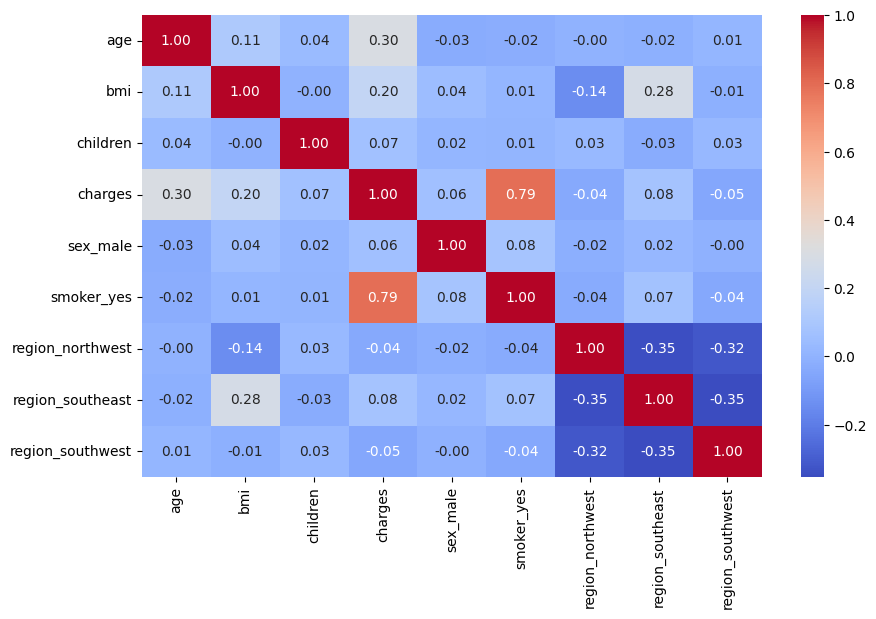

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [11]:
X = df.drop(columns=['charges'])
y = df['charges']



In [12]:
print("Remaining features:", X.columns)
print("Shape of X:", X.shape)

Remaining features: Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')
Shape of X: (2772, 8)


In [13]:
print(X.isnull().sum())  # Check for NaN values


age                 0
bmi                 0
children            0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


In [14]:

print(np.isinf(X).sum())  # Check for Infinite values

age                 0
bmi                 0
children            0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


In [15]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            Feature        VIF
0               age   7.660716
1               bmi  11.446177
2          children   1.802120
3          sex_male   2.008999
4        smoker_yes   1.262573
5  region_northwest   1.891156
6  region_southeast   2.318038
7  region_southwest   1.993584


In [16]:
X = X[vif_data[vif_data["VIF"] < 5]['Feature']]

In [17]:
model = LinearRegression()
n_features = min(10, X.shape[1])
rfe = RFE(model, n_features_to_select=n_features)
X_selected = rfe.fit_transform(X, y)
selected_features = X.columns[rfe.support_]
X = X[selected_features]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(2217, 6) (555, 6)


In [19]:
power_transformer = PowerTransformer()
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)


In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f"{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.4f}\n")

    cv_r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='r2')
    print(f"{name} CV R2 Score: {cv_r2_scores.mean():.4f} (+/- {cv_r2_scores.std():.4f})\n")
    print("=" * 80)


Linear Regression Performance:
MAE: 5888.7463
MSE: 60140969.2825
R2 Score: 0.6082

Linear Regression CV R2 Score: 0.6285 (+/- 0.0237)

Ridge Regression Performance:
MAE: 5889.2921
MSE: 60146062.4753
R2 Score: 0.6081

Ridge Regression CV R2 Score: 0.6285 (+/- 0.0237)

Lasso Regression Performance:
MAE: 5888.7592
MSE: 60141148.1214
R2 Score: 0.6082

Lasso Regression CV R2 Score: 0.6285 (+/- 0.0237)

Random Forest Performance:
MAE: 5578.0117
MSE: 54959754.5059
R2 Score: 0.6419

Random Forest CV R2 Score: 0.6442 (+/- 0.0206)



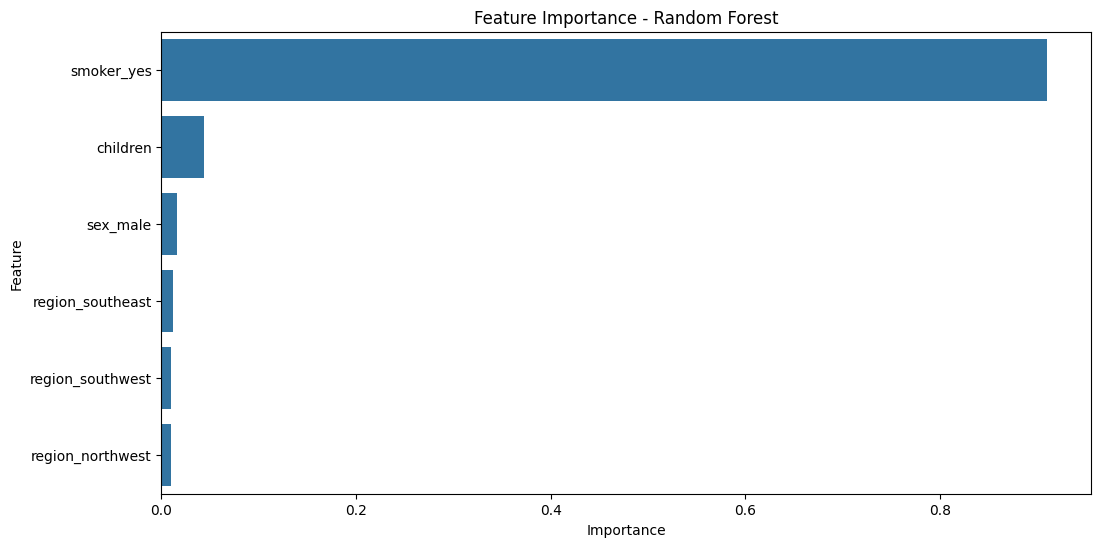

In [23]:
feature_importances = models["Random Forest"].feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.title("Feature Importance - Random Forest")
plt.show()


In [24]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='r2', n_jobs=-1, random_state=42)
rand_search.fit(X_train_scaled, y_train)

print("Best Parameters:", rand_search.best_params_)
print("Best Score:", rand_search.best_score_)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Best Score: 0.64706709707091


In [25]:
joblib.dump(rand_search.best_estimator_, 'insurance_cost_model.pkl')

print("Model saved successfully!")


Model saved successfully!
